# Aim

Test out LQG control on some random system I throw together, so I'm familiar with the syntax and effectiveness.

In [8]:
using ControlSystems
using NPZ
using LinearAlgebra
using Revise
using ttsysid

eye(n) = Matrix{Float64}(I,n,n)
openloops = npzread("../data/sims/atm_openloops.npy")[:,1];

In [9]:
ar_len = 2
kf = make_kfilter_ar(ar_len, openloops[1:100])
sys_ar = ss(kf.A, kf.B, kf.C, 0.0)

Took 11 iterations to reach steady-state covariance.


StateSpace{Continuous, Float64}
A = 
 1.6602288107201026  -0.6861536003228691
 1.0                  0.0
B = 
 1.0
 0.0
C = 
 1.0  0.0
D = 
 0.0

Continuous-time state-space model

In [17]:
G = LQG(sys_ar, eye(2), eye(1), kf.Q, kf.R, qQ=1, qR=0)

LQG(StateSpace{Continuous, Float64}
A = 
 1.6602288107201026  -0.6861536003228691
 1.0                  0.0
B = 
 1.0
 0.0
C = 
 1.0  0.0
D = 
 0.0

Continuous-time state-space model, [1.0 0.0; 0.0 1.0], [1.0], [0.008381314805331297 0.0; 0.0 0.0], [0.0036], 1, 0, StateSpace{Continuous, Float64}
A = 
 -6.325421890572878   -1.212768223213338
  1.0000000000000078   0.0
B = 
  3.9151129996366922
 -7.70261890434369e-15
C = 
 4.0705377016562885  0.526614622890469
D = 
 0.0

Continuous-time state-space model, [4.0705377016562885 0.526614622890469], [3.9151129996366922; -7.70261890434369e-15], [1.0 0.0], false)

In [18]:
G.cl

StateSpace{Continuous, Float64}
A = 
 -2.410308890936186  -1.212768223213338   4.0705377016562885   0.526614622890469
  1.0                 0.0                 0.0                  0.0
  0.0                 0.0                -2.2548841889165896  -0.6861536003228691
  0.0                 0.0                 1.0000000000000078   0.0
B = 
 2.1710132446136e16
 0.0
 0.0
 0.0
C = 
 1.0  0.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model

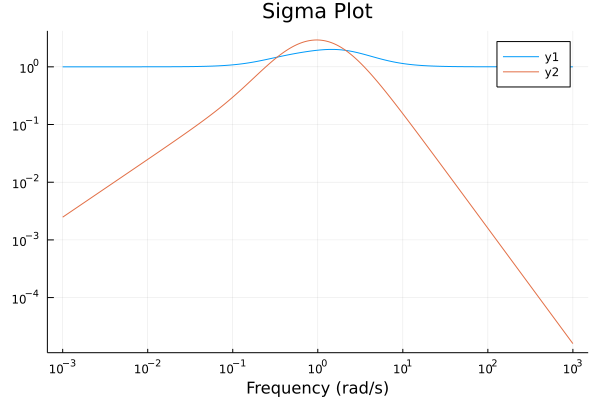

In [19]:
Gcl = G.cl
T = G.T
S = G.S
sigmaplot([S,T], exp10.(range(-3, stop=3, length=1000)))

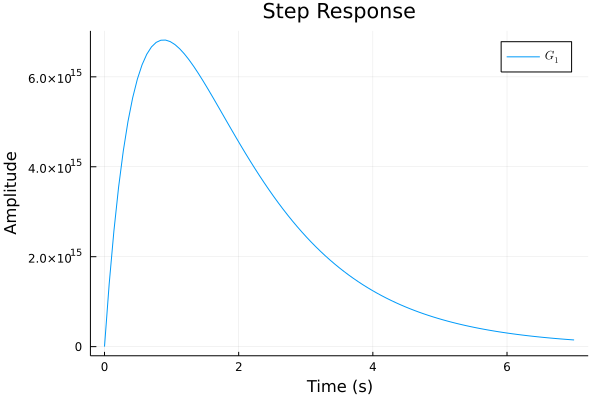

In [20]:
stepplot(Gcl)

In [21]:
dampreport(Gcl)

|     Pole      |   Damping     |   Frequency   | Time Constant |
|               |    Ratio      |   (rad/sec)   |     (sec)     |
+---------------+---------------+---------------+---------------+
|  -3.626e-01   |  1.000e+00    |  3.626e-01    |  2.758e+00    |
|  -7.156e-01   |  1.000e+00    |  7.156e-01    |  1.397e+00    |
|  -1.695e+00   |  1.000e+00    |  1.695e+00    |  5.901e-01    |
|  -1.892e+00   |  1.000e+00    |  1.892e+00    |  5.285e-01    |
